In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath(".")))

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

In [3]:
# HYPERPARAMETER
RESULT_DIR = "../result/CAT/3p_da_pm_pp.msv/"
# RESULT_DIR = "../result/CAT/3p_sa_pm_pp.msv/"

In [4]:
# PREDS SAVE MOT2D RESULT AS DICT, WITH KEY INDICATING FRAME ID, VALUE INDICATE TRACKED OBJECT (TID, BBOX)
preds = {}
with open(osp.join(RESULT_DIR, 'pred.txt'), 'r') as f:
    lines = [ line for line in f.read().split('\n') if len(line) > 0 ]
    for line in lines:
        fields = [ f for f in line.split(",") if len(f) > 0 ]
        fid = int(fields[0])
        tid = fields[1]
        bbox = np.array([ float(v) for v in fields[2:2+4] ])
        bbox[2] = bbox[0] + bbox[2]
        bbox[3] = bbox[1] + bbox[3]
        if fid not in preds:
            preds[fid] = []
        preds[fid].append((tid, bbox))

In [5]:
# SNAPSHOTS IS A LIST OF SNAPSHOT, A SNAPSHOT RECORDS FEATURE REPRESENTATION ON EACH TRACK
with open(osp.join(RESULT_DIR, 'snapshots_pools.pkl'), 'rb') as f:
    snapshots_pools = pickle.load(f)

In [6]:
unique_ids = []
for snapshots in snapshots_pools:
    ids = list(snapshots.keys())
    unique_ids += ids

print("IDs:", set(unique_ids))

IDs: {0, 1, 3}


In [7]:
# WHICH TRACKS I WANT TO AGGREGATE ALL THE FEATURES
# 0 -> benny
# 1 -> hunyan
# 2 -> shijun
TARGET_TRACKS = list(set(unique_ids))#[:-1]

In [8]:
# AGGREGATE TARGET FEATURES TOGETHER
target_feature_pools = {}

for idx, snapshot_pools in enumerate(snapshots_pools):
    for tid, pools in snapshot_pools.items():
        if tid in TARGET_TRACKS:
            if tid == 8:
                tid = 5
            if tid not in target_feature_pools:
                target_feature_pools[tid] = {}
            for k, v in pools.items():
                if k not in target_feature_pools[tid]:
                    target_feature_pools[tid][k] = []
                target_feature_pools[tid][k].append(np.array(v).mean(axis=0).reshape(-1))
                
for tid in target_feature_pools.keys():
    for k, v in target_feature_pools[tid].items():
        target_feature_pools[tid][k] = np.array(v)

In [9]:
N_SAMPLES = 100

target_sub_pools = {}
for tid, feature_pools in target_feature_pools.items():
    if tid not in target_sub_pools:
        target_sub_pools[tid] = {}
    for k, features in feature_pools.items():
        indices = np.random.choice(np.arange(len(features)), N_SAMPLES, replace=False)
        target_sub_pools[tid][k] = features[indices]
    
all_features = []
for tid, sub_pools in target_sub_pools.items():
    buffer = []
    for i in range(4):
        buffer.append(sub_pools[i])
    all_features.append(np.concatenate(buffer).tolist())
all_features = np.array(all_features)

In [10]:
data = all_features.reshape(-1, 128)

In [11]:
# Visualization
pca = PCA(n_components=64)
reduced = pca.fit_transform(data)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
reduced = tsne.fit_transform(reduced)

In [12]:
reduced.shape

(1200, 2)

In [13]:
target_reduced = reduced.reshape(3, 4*N_SAMPLES, 2)
print(target_reduced.shape)

(3, 400, 2)


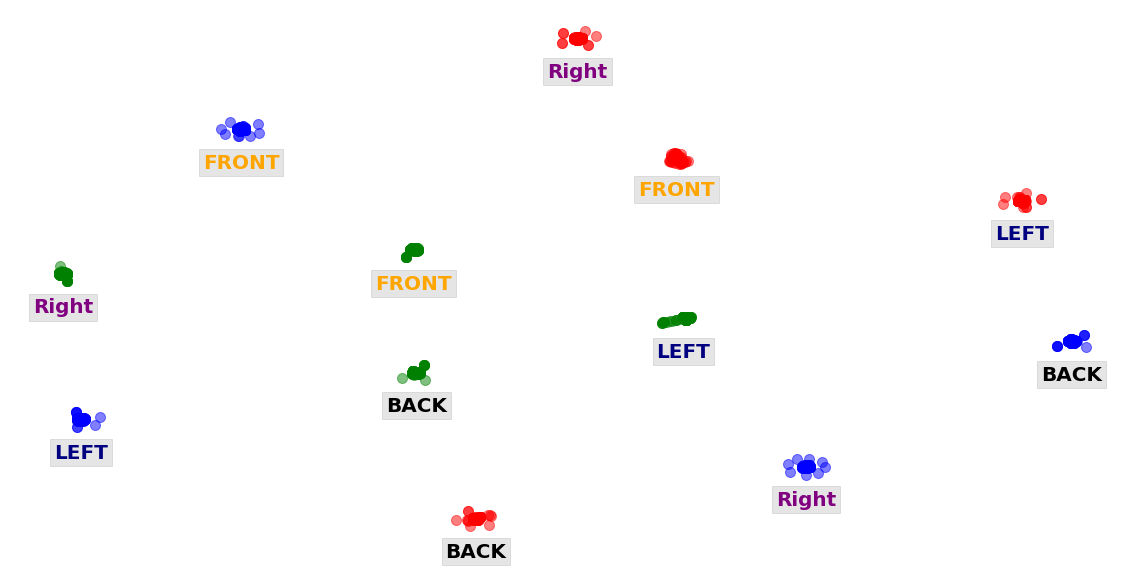

In [14]:
plt.figure(figsize=(16, 8))

for tid in range(3):
    features = target_reduced[tid]
    if tid == 0:
        color = 'red'
    elif tid == 1:
        color = 'blue'
    elif tid == 2:
        color = 'green'
        
    for i in range(4):
        start = i*N_SAMPLES
        end = i*N_SAMPLES + N_SAMPLES
        if i == 0:
            text = "FRONT"
            tcolor = "orange"
        elif i == 1:
            text = "Right"
            tcolor = "purple"
        elif i == 2:
            text = "BACK"
            tcolor = "black"
        else:
            text = "LEFT"
            tcolor = "navy"
        x = np.mean(features[start:end, 0])
        y = np.mean(features[start:end, 1]) - 5
        text_params = {'ha': 'center', 'va': 'center', 'color': tcolor, 'fontsize': 20, 'fontweight': 'bold'}
        plt.text(x, y, text, bbox=dict(facecolor='black', alpha=0.1), **text_params)
        plt.scatter(features[start:end, 0], features[start:end, 1], s=100, alpha=0.5, color=color)
        
plt.axis('off')
plt.tight_layout()